In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils import Bunch

In [2]:
# df = pd.read_csv("/home/athyrson/Code/Data/Raw Data/Lending Club/accepted_2007_to_2018Q4.csv")

In [3]:
# Define the chunk size for reading the CSV file
chunksize = 100000  # Adjust this value based on your requirements

# Initialize an empty list to store filtered chunks
filtered_chunks = []

# Read the CSV file in chunks based on the defined chunk size
for chunk in pd.read_csv("/home/athyrson/Code/Data/Raw Data/Lending Club/accepted_2007_to_2018Q4.csv", chunksize=chunksize):
    # Filter the current chunk based on the criteria
    filtered_chunk = chunk[chunk['issue_d'].str.contains("2010", na=False)]
    # filtered_chunk = filtered_chunk[~filtered_chunk['issue_d'].str.contains("Oct-2013|Nov-2013|Dec-2013", na=False)]
    # Append the filtered chunk to the list
    filtered_chunks.append(filtered_chunk)

# Concatenate all filtered chunks into a single DataFrame
df = pd.concat(filtered_chunks)


/tmp/ipykernel_17597/2038679434.py:8: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("/home/athyrson/Code/Data/Raw Data/Lending Club/accepted_2007_to_2018Q4.csv", chunksize=chunksize):
/tmp/ipykernel_17597/2038679434.py:8: DtypeWarning: Columns (19,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("/home/athyrson/Code/Data/Raw Data/Lending Club/accepted_2007_to_2018Q4.csv", chunksize=chunksize):
/tmp/ipykernel_17597/2038679434.py:8: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("/home/athyrson/Code/Data/Raw Data/Lending Club/accepted_2007_to_2018Q4.csv", chunksize=chunksize):
/tmp/ipykernel_17597/2038679434.py:8: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("/home/athyrson/Code/Data/Raw Dat

In [4]:
df_1 = df.sample(frac=1, random_state=42)
df_1.shape

(12537, 151)

In [5]:
import re

def preprocess_data(df):
    # Calculate risk score
    df["risk_score"] = df.loc[:, ["last_fico_range_high", "last_fico_range_low"]].mean(axis=1)
    
    # Create target variable
    df["target"] = np.where((df.loan_status == 'Current') |
                            (df.loan_status == 'Fully Paid') |
                            (df.loan_status == "Issued") |
                            (df.loan_status == 'Does not meet the credit policy. Status:Fully Paid'), 0, 1)
    
    # Drop unnecessary columns
    for c in ['last_fico_range_high', 'last_fico_range_low', 'loan_status']:
        df = df.drop(c, axis=1, errors='ignore')
    
    def fix_term_column(df):
        """
        Fix the dtype of the 'term' column by extracting the numeric part and converting it to an integer.
        Handles cases where the column contains non-string values (e.g., NaN or float).
        
        Parameters:
            df (pd.DataFrame): The DataFrame containing the 'term' column.
        
        Returns:
            pd.DataFrame: The DataFrame with the 'term' column converted to numeric.
        """
        try:
            # Extract numeric part from the 'term' column and convert to integer
            df['term'] = df['term'].apply(lambda x: int(re.search(r'\d+', str(x)).group()) if pd.notna(x) else x)
        except AttributeError as e:
            # Handle cases where the regex search fails (e.g., no match found)
            print("Error: Unable to extract numeric value from 'term' column.")
            print(f"Details: {e}")
        except Exception as e:
            # Handle any other unexpected errors
            print("An unexpected error occurred while fixing the 'term' column.")
            print(f"Details: {e}")
        
        return df
    
    def fix_emp_length_column(df):
        """
        Fix the dtype of the 'emp_length' column by converting it to numeric.
        Handles cases where the column contains non-string values (e.g., NaN or float).
        
        Parameters:
            df (pd.DataFrame): The DataFrame containing the 'emp_length' column.
        
        Returns:
            pd.DataFrame: The DataFrame with the 'emp_length' column converted to numeric.
        """
        try:
            # Map '< 1 year' to '0' and extract numeric part from the 'emp_length' column
            df['emp_length'] = df['emp_length'].map(lambda x: "0" if x == '< 1 year' else x)
            df['emp_length'] = df['emp_length'].map(lambda x: int(re.search(r'\d+', str(x)).group()), na_action='ignore')
        except Exception as e:
            # Handle any unexpected errors
            print("Error: Unable to convert 'emp_length' column to numeric.")
            print(f"Details: {e}")
        
        return df
    
    df = fix_term_column(df)
    df = fix_emp_length_column(df)

    return df

In [6]:
df_2 = preprocess_data(df_1)
df_2

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,risk_score,target
1643125,498726,NaN,5000.0,5000.0,5000.000000,36,11.36,164.56,B,B5,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,732.0,0
1636584,597920,NaN,10000.0,10000.0,9861.357548,36,7.88,312.82,A,A5,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,682.0,0
1639847,543951,NaN,8700.0,8700.0,8700.000000,36,7.51,270.67,A,A4,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,787.0,0
1643531,492732,NaN,4000.0,4000.0,4000.000000,36,7.88,125.13,A,A5,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,712.0,0
1640954,528880,NaN,10000.0,10000.0,9362.071323,36,7.14,309.42,A,A3,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,822.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652094,562187,NaN,13800.0,13800.0,13800.000000,36,16.32,487.36,D,D5,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,602.0,0
1638791,562457,NaN,8000.0,8000.0,8000.000000,36,7.14,247.53,A,A3,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,812.0,0
1638990,557251,NaN,5000.0,5000.0,4500.000000,36,14.84,172.94,D,D1,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,707.0,0
1634460,624384,NaN,10000.0,10000.0,9950.000000,60,13.35,229.33,C,C4,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,702.0,0


In [7]:
def create_bunch_df(X,y):
    # Convert to NumPy arrays
    X_array = X.to_numpy()
    y_array = y.to_numpy()

    # Get feature names
    feature_names = X.columns.tolist()

    # Create a Bunch object
    bunch_df = Bunch(
        data=X_array,
        target=y_array,
        feature_names=feature_names,
        DESCR="Custom dataset similar to scikit-learn fetch_datasets"
    )
    return bunch_df

In [8]:
drop_list = [
    'issue_d', 'url', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_pymnt_d', 'pymnt_plan', 'recoveries', 
    'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'hardship_flag', 
    'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 
    'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 
    'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 
    'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 
    'settlement_percentage', 'settlement_term', 'id', 'emp_title', 'desc', 'title', 'last_credit_pull_d', 'next_pymnt_d'
]

In [9]:
X = df_2.loc[:, df_2.columns != 'target'].drop(drop_list, axis=1)#, 'risk_score'
y = df_2['target']

df_3 = create_bunch_df(X, y)
X = df_3.data
y = df_3.target
feature_names = df_3.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import TargetEncoder
from interpret.glassbox import ExplainableBoostingClassifier  # Import EBM

# Train benchmark models with all features
# Logistic Regression
log_reg = make_pipeline(TargetEncoder(), StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]

# Decision Tree Classifier
tree_clf = make_pipeline(TargetEncoder(), StandardScaler(), DecisionTreeClassifier(max_depth=5, random_state=42))
tree_clf.fit(X_train, y_train)
tree_clf_pred = tree_clf.predict_proba(X_test)[:, 1]

# Gradient Boosting Classifier
gb_clf = make_pipeline(TargetEncoder(), StandardScaler(), GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42))
gb_clf.fit(X_train, y_train)
gb_clf_pred = gb_clf.predict_proba(X_test)[:, 1]

# Explainable Boosting Machine (EBM)
ebm = make_pipeline( TargetEncoder(), StandardScaler(), ExplainableBoostingClassifier(random_state=42))
ebm.fit(X_train, y_train)
ebm_pred = ebm.predict_proba(X_test)[:, 1]

# Evaluate performance of benchmark models
log_reg_auc = roc_auc_score(y_test, log_reg_pred)
log_reg_recall = recall_score(y_test, log_reg_pred.round())
log_reg_balanced_acc = balanced_accuracy_score(y_test, log_reg_pred.round())

tree_clf_auc = roc_auc_score(y_test, tree_clf_pred)
tree_clf_recall = recall_score(y_test, tree_clf_pred.round())
tree_clf_balanced_acc = balanced_accuracy_score(y_test, tree_clf_pred.round())

gb_clf_auc = roc_auc_score(y_test, gb_clf_pred)
gb_clf_recall = recall_score(y_test, gb_clf_pred.round())
gb_clf_balanced_acc = balanced_accuracy_score(y_test, gb_clf_pred.round())

ebm_auc = roc_auc_score(y_test, ebm_pred)
ebm_recall = recall_score(y_test, ebm_pred.round())
ebm_balanced_acc = balanced_accuracy_score(y_test, ebm_pred.round())

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree Classifier", "Gradient Boosting Classifier", "Explainable Boosting Machine (EBM)"],
    "AUC": [log_reg_auc, tree_clf_auc, gb_clf_auc, ebm_auc],
    "Recall": [log_reg_recall, tree_clf_recall, gb_clf_recall, ebm_recall],
    "Balanced Accuracy": [log_reg_balanced_acc, tree_clf_balanced_acc, gb_clf_balanced_acc, ebm_balanced_acc]
})

# Display the DataFrame
results_df.round(3)

,Model,AUC,Recall,Balanced Accuracy
0,Logistic Regression,0.830,0.269,0.619
1,Decision Tree Classifier,0.821,0.335,0.643
2,Gradient Boosting Classifier,0.832,0.017,0.508
3,Explainable Boosting Machine (EBM),0.831,0.278,0.622


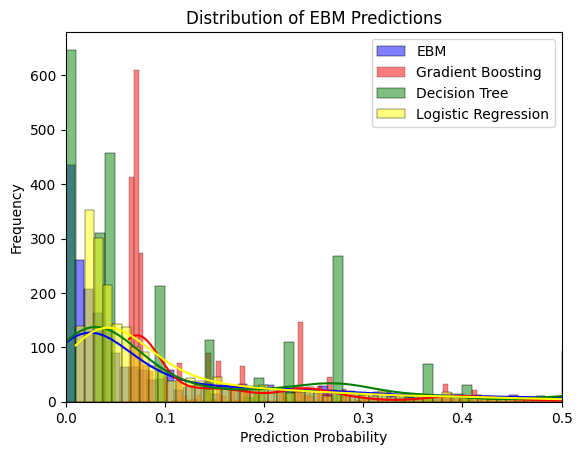

In [11]:
import seaborn as sns

# Plot the distribution of ebm_pred
sns.histplot(ebm_pred, kde=True, bins=100, color='blue', label = "EBM")
sns.histplot(gb_clf_pred, kde=True, bins=100, color='red', label = "Gradient Boosting")
sns.histplot(tree_clf_pred, kde=True, bins=100, color='green', label = "Decision Tree")
sns.histplot(log_reg_pred, kde=True, color='yellow', bins=100, label = "Logistic Regression")
plt.title("Distribution of EBM Predictions")
plt.xlabel("Prediction Probability")

plt.xlim(0,0.5)
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [12]:
X = df_2.loc[:, df_2.columns != 'target'].drop(drop_list, axis=1)#, 'risk_score'
y = df_2['target']

# df_3 = create_bunch_df(X, y)
# X = df_3.data
# y = df_3.target
# feature_names = df_3.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, balanced_accuracy_score
import pandas as pd
from interpret.glassbox import ExplainableBoostingClassifier  # Import EBM

# Train benchmark models with all features



# Explainable Boosting Machine (EBM)
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)
ebm_pred = ebm.predict_proba(X_test)[:, 1]

# Evaluate performance of benchmark models
ebm_auc = roc_auc_score(y_test, ebm_pred)
ebm_recall = recall_score(y_test, ebm_pred.round())
ebm_balanced_acc = balanced_accuracy_score(y_test, ebm_pred.round())

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree Classifier", "Gradient Boosting Classifier", "Explainable Boosting Machine (EBM)"],
    "AUC": [log_reg_auc, tree_clf_auc, gb_clf_auc, ebm_auc],
    "Recall": [log_reg_recall, tree_clf_recall, gb_clf_recall, ebm_recall],
    "Balanced Accuracy": [log_reg_balanced_acc, tree_clf_balanced_acc, gb_clf_balanced_acc, ebm_balanced_acc]
})

# Display the DataFrame
results_df.round(3)

/home/athyrson/.local/lib/python3.13/site-packages/interpret/utils/_preprocessor.py:358: RuntimeWarning: All-NaN slice encountered
  min_feature_val = np.nanmin(X_col)
/home/athyrson/.local/lib/python3.13/site-packages/interpret/utils/_preprocessor.py:359: RuntimeWarning: All-NaN slice encountered
  max_feature_val = np.nanmax(X_col)
/home/athyrson/.local/lib/python3.13/site-packages/interpret/glassbox/_ebm/_ebm.py:813: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


,Model,AUC,Recall,Balanced Accuracy
0,Logistic Regression,0.830,0.269,0.619
1,Decision Tree Classifier,0.821,0.335,0.643
2,Gradient Boosting Classifier,0.832,0.017,0.508
3,Explainable Boosting Machine (EBM),0.839,0.309,0.636


In [14]:
from interpret import show
show(ebm.explain_global())

<!-- http://127.0.0.1:7001/140002899365904/ -->

In [15]:
df_2.query("target == 1").shape[0]/df_2.shape[0]

0.14014517029592408

In [16]:
pd.concat([df_2.query("target == 1"), 
           df_2.query("target == 0").sample(frac = 0.14, random_state = 42)],
           axis = 0
           )

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,risk_score,target
1639459,552237,NaN,5000.0,5000.0,5000.000000,36,13.23,169.03,C,C1,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,592.0,1
1636955,591799,NaN,8000.0,8000.0,8000.000000,60,11.49,175.91,B,B4,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,657.0,1
1644071,486744,NaN,3000.0,3000.0,2950.000000,36,10.62,97.68,B,B3,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,249.5,1
1634567,626248,NaN,9700.0,9700.0,9175.000000,36,8.88,307.92,B,B1,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,557.0,1
1640556,535336,NaN,8500.0,8500.0,8318.139253,36,7.14,263.00,A,A3,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,767.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635189,616874,NaN,20000.0,12325.0,11311.135722,36,6.54,377.98,A,A4,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,747.0,0
1641401,522080,NaN,15200.0,6825.0,6795.543750,60,15.58,164.46,D,D3,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,697.0,0
1641078,526705,NaN,2500.0,2500.0,2500.000000,36,13.61,84.98,C,C2,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,597.0,0
1634642,624831,NaN,6400.0,6400.0,6400.000000,60,15.57,154.18,D,D5,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,587.0,0


In [17]:
X = df_2.loc[:, df_2.columns != 'target'].drop(drop_list, axis=1)#, 'risk_score'
y = df_2['target']

df_3 = create_bunch_df(X, y)
X = df_3.data
y = df_3.target
feature_names = df_3.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import TargetEncoder
from interpret.glassbox import ExplainableBoostingClassifier  # Import EBM

# Train benchmark models with all features
# Logistic Regression
log_reg = make_pipeline(TargetEncoder(), StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]

# Decision Tree Classifier
tree_clf = make_pipeline(TargetEncoder(), StandardScaler(), DecisionTreeClassifier(max_depth=5, random_state=42))
tree_clf.fit(X_train, y_train)
tree_clf_pred = tree_clf.predict_proba(X_test)[:, 1]

# Gradient Boosting Classifier
gb_clf = make_pipeline(TargetEncoder(), StandardScaler(), GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42))
gb_clf.fit(X_train, y_train)
gb_clf_pred = gb_clf.predict_proba(X_test)[:, 1]

# Explainable Boosting Machine (EBM)
ebm = make_pipeline( TargetEncoder(), StandardScaler(), ExplainableBoostingClassifier(random_state=42))
ebm.fit(X_train, y_train)
ebm_pred = ebm.predict_proba(X_test)[:, 1]

# Evaluate performance of benchmark models
log_reg_auc = roc_auc_score(y_test, log_reg_pred)
log_reg_recall = recall_score(y_test, log_reg_pred.round())
log_reg_balanced_acc = balanced_accuracy_score(y_test, log_reg_pred.round())

tree_clf_auc = roc_auc_score(y_test, tree_clf_pred)
tree_clf_recall = recall_score(y_test, tree_clf_pred.round())
tree_clf_balanced_acc = balanced_accuracy_score(y_test, tree_clf_pred.round())

gb_clf_auc = roc_auc_score(y_test, gb_clf_pred)
gb_clf_recall = recall_score(y_test, gb_clf_pred.round())
gb_clf_balanced_acc = balanced_accuracy_score(y_test, gb_clf_pred.round())

ebm_auc = roc_auc_score(y_test, ebm_pred)
ebm_recall = recall_score(y_test, ebm_pred.round())
ebm_balanced_acc = balanced_accuracy_score(y_test, ebm_pred.round())

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree Classifier", "Gradient Boosting Classifier", "Explainable Boosting Machine (EBM)"],
    "AUC": [log_reg_auc, tree_clf_auc, gb_clf_auc, ebm_auc],
    "Recall": [log_reg_recall, tree_clf_recall, gb_clf_recall, ebm_recall],
    "Balanced Accuracy": [log_reg_balanced_acc, tree_clf_balanced_acc, gb_clf_balanced_acc, ebm_balanced_acc]
})

# Display the DataFrame
results_df.round(3)

,Model,AUC,Recall,Balanced Accuracy
0,Logistic Regression,0.830,0.278,0.623
1,Decision Tree Classifier,0.822,0.307,0.629
2,Gradient Boosting Classifier,0.831,0.000,0.500
3,Explainable Boosting Machine (EBM),0.834,0.309,0.635


In [19]:
X = df_2.loc[:, df_2.columns != 'target'].drop(drop_list, axis=1)#, 'risk_score'
y = df_2['target']

# df_3 = create_bunch_df(X, y)
# X = df_3.data
# y = df_3.target
# feature_names = df_3.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, balanced_accuracy_score
import pandas as pd
from interpret.glassbox import ExplainableBoostingClassifier  # Import EBM

# Train benchmark models with all features



# Explainable Boosting Machine (EBM)
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)
ebm_pred = ebm.predict_proba(X_test)[:, 1]

# Evaluate performance of benchmark models
ebm_auc = roc_auc_score(y_test, ebm_pred)
ebm_recall = recall_score(y_test, ebm_pred.round())
ebm_balanced_acc = balanced_accuracy_score(y_test, ebm_pred.round())

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree Classifier", "Gradient Boosting Classifier", "Real Explainable Boosting Machine (EBM)"],
    "AUC": [log_reg_auc, tree_clf_auc, gb_clf_auc, ebm_auc],
    "Recall": [log_reg_recall, tree_clf_recall, gb_clf_recall, ebm_recall],
    "Balanced Accuracy": [log_reg_balanced_acc, tree_clf_balanced_acc, gb_clf_balanced_acc, ebm_balanced_acc]
})

# Display the DataFrame
results_df.round(3)

/home/athyrson/.local/lib/python3.13/site-packages/interpret/utils/_preprocessor.py:358: RuntimeWarning:

All-NaN slice encountered

/home/athyrson/.local/lib/python3.13/site-packages/interpret/utils/_preprocessor.py:359: RuntimeWarning:

All-NaN slice encountered

/home/athyrson/.local/lib/python3.13/site-packages/interpret/glassbox/_ebm/_ebm.py:813: UserWarning:

Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]



,Model,AUC,Recall,Balanced Accuracy
0,Logistic Regression,0.830,0.278,0.623
1,Decision Tree Classifier,0.822,0.307,0.629
2,Gradient Boosting Classifier,0.831,0.000,0.500
3,Real Explainable Boosting Machine (EBM),0.839,0.309,0.636


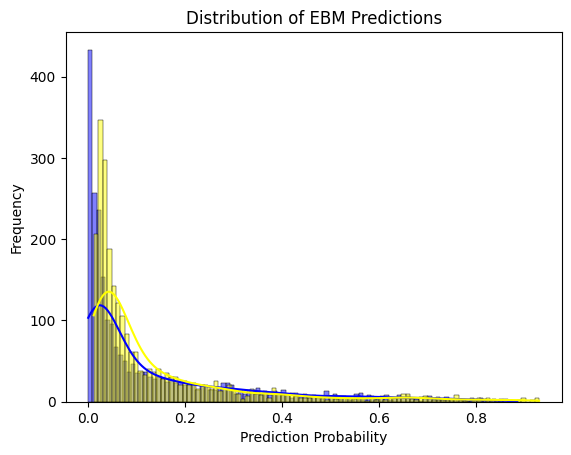

In [21]:
import seaborn as sns

# Plot the distribution of ebm_pred
sns.histplot(ebm_pred, kde=True, bins=100, color='blue')
# sns.histplot(gb_clf_pred, kde=True, bins=100, color='red')
# sns.histplot(tree_clf_pred, kde=True, bins=100, color='green')
sns.histplot(log_reg_pred, kde=True, bins=100, color='yellow')
plt.title("Distribution of EBM Predictions")
plt.xlabel("Prediction Probability")
plt.ylabel("Frequency")
plt.show()